In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import numpy as np
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('responsi_data.csv', delimiter=';')
df.head()

,id,kode_produk,review,aspect_term_sentiment
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]"""
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]"""
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},..."
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]"""
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]"""


In [3]:
def get_first_polarity(sentiment_str):
    try:
        if sentiment_str.startswith('"""') and sentiment_str.endswith('"""'):
            sentiment_str = sentiment_str[3:-3]
        elif sentiment_str.startswith('"') and sentiment_str.endswith('"'):
            sentiment_str = sentiment_str[1:-1]

        sentiment_list = ast.literal_eval(sentiment_str)

        if sentiment_list and len(sentiment_list) > 0:
            return sentiment_list[0]['polarity']
        return None
    except (ValueError, SyntaxError, KeyError, IndexError):
        return None

df['sentiment'] = df['aspect_term_sentiment'].apply(get_first_polarity)
df.head()


,id,kode_produk,review,aspect_term_sentiment,sentiment
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]""",positive
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},...",positive
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]""",neutral


## Preprocessing

#### Visualisasi

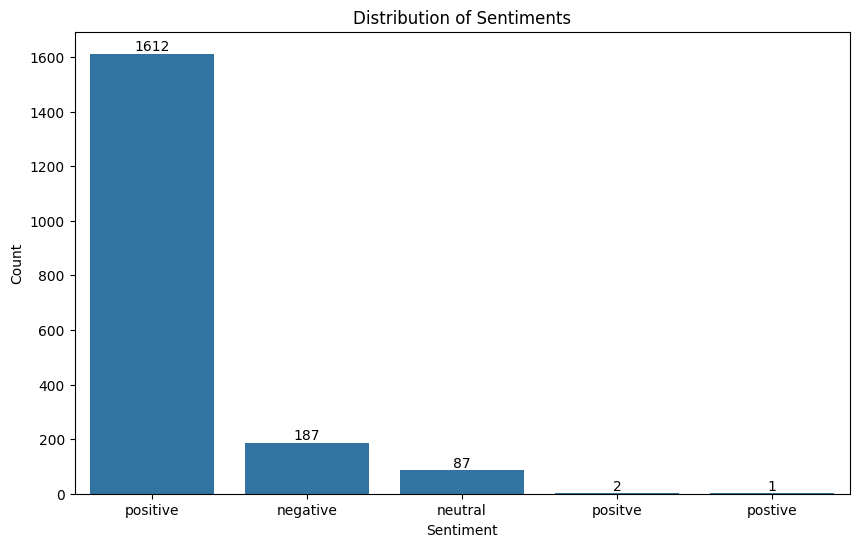

In [4]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


#### Preprocessing

In [5]:
df['sentiment'] = df['sentiment'].replace(['positve', 'postive'], 'positive')

In [6]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stopwords = StopWordRemoverFactory().get_stop_words()

In [16]:
import re
import pandas as pd
from tqdm import tqdm

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[0-9]+|[^\w\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in stopwords]

    text = ' '.join(words)

    return text

batch_size = 1000
processed_reviews = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df['review'].iloc[i:i+batch_size]
    processed = [preprocess_text(text) for text in batch]
    processed_reviews.extend(processed)

df['processed_review'] = processed_reviews

df.head()

100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


,id,kode_produk,review,aspect_term_sentiment,sentiment,processed_review
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive,akhirnya lengkap mulai lengkap variant jujurly...
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]""",positive,kalo sunscreen spray i only trust skintific in...
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},...",positive,sunscreen terbagus a ngl benaran se lightweigh...
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive,produk krim perawatan wajah memberikan pengala...
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]""",neutral,cepat habis padahal beli gede aku pakainya tia...


In [8]:
indo_slang_word = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")

slang_dict = dict(zip(indo_slang_word['slang'], indo_slang_word['formal']))

def replace_slang_words(text):
    words = text.split()
    replaced_words = []

    for word in words:
        if word in slang_dict:
            replaced_words.append(slang_dict[word])
        else:
            replaced_words.append(word)

    return ' '.join(replaced_words)

df['processed_review'] = df['processed_review'].apply(replace_slang_words)

#### Visualisasi Worldcloud

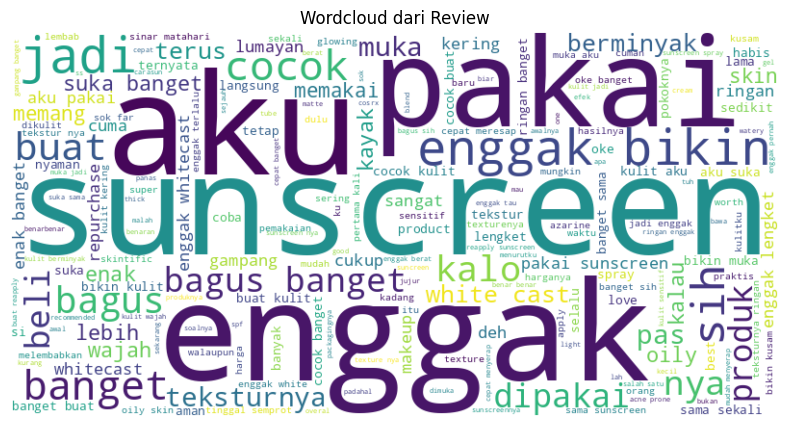

In [9]:
text = ' '.join(df['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud dari Review')
plt.show()


## Term Weighting

In [12]:
!pip install gensim

In [17]:
tokenized_reviews = df['processed_review'].apply(lambda x: x.split())

# model Word2Vec
w2v_model = Word2Vec(sentences=tokenized_reviews,
                    vector_size=100,
                    window=5,
                    min_count=2,
                    workers=4)

def get_document_vector(text, model):
    words = text.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

document_vectors = df['processed_review'].apply(lambda x: get_document_vector(x, w2v_model))

X = np.array(document_vectors.tolist())

print(X[:5])


[[-6.02924302e-02  2.07078159e-01 -1.08939752e-01 -2.01692656e-02
   3.73697281e-02 -4.37868297e-01  2.96593338e-01  7.46956527e-01
  -2.90739864e-01 -3.11316937e-01 -6.80394769e-02 -4.00526106e-01
  -8.75463858e-02  1.69469431e-01  5.15068956e-02 -1.16679281e-01
   2.42479011e-01 -3.24188679e-01 -8.02863687e-02 -7.47724235e-01
   1.07235365e-01  1.08167231e-01  9.49004441e-02 -2.78137863e-01
  -1.66239813e-01  5.65499850e-02 -2.36840412e-01 -1.65259451e-01
  -1.78537816e-01  9.81192812e-02  3.55600655e-01 -4.43532281e-02
   1.33008316e-01 -3.06234658e-01 -1.91145822e-01  3.45970571e-01
   8.16527903e-02 -1.53139457e-01 -9.37681571e-02 -5.70117831e-01
   8.16025026e-03 -2.10243300e-01 -8.53206068e-02  4.94684093e-02
   3.08741719e-01 -4.99340408e-02 -3.28347296e-01 -6.38340190e-02
   2.09390461e-01  1.89077392e-01  4.40182053e-02 -3.07590336e-01
  -9.93113667e-02 -1.47058770e-01 -8.81782025e-02  1.23386279e-01
   1.41369775e-01 -1.49566066e-02 -3.18415880e-01  1.41408920e-01
   9.51660

## Classification

In [23]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}

df_clean = df.dropna(subset=['sentiment']).copy()

X = np.array(df_clean['processed_review'].apply(lambda x: get_document_vector(x, w2v_model)).tolist())
y = df_clean['sentiment'].map(sentiment_map).values

print("Original class distribution:", Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Class distribution after SMOTE:", Counter(y_smote))

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote,
                                                                            y_smote,
                                                                            test_size=0.2,
                                                                            random_state=42)

svm_model_smote = SVC(kernel='rbf', random_state=42)
svm_model_smote.fit(X_train_smote, y_train_smote)

predictions_smote = svm_model_smote.predict(X_test_smote)

predictions_text_smote = [label_map[pred] for pred in predictions_smote]
actual_labels_text_smote = [label_map[label] for label in y_test_smote]

print("\nClassification Report after SMOTE:")
print(classification_report(actual_labels_text_smote, predictions_text_smote))

Original class distribution: Counter({2: 1615, 0: 187, 1: 87})
Class distribution after SMOTE: Counter({2: 1615, 1: 1615, 0: 1615})

Classification Report after SMOTE:
              precision    recall  f1-score   support

    negative       0.35      0.64      0.45       304
     neutral       0.45      0.29      0.35       325
    positive       0.55      0.31      0.40       340

    accuracy                           0.41       969
   macro avg       0.45      0.42      0.40       969
weighted avg       0.45      0.41      0.40       969



In [24]:
from sklearn.metrics import classification_report

print(classification_report(actual_labels_text_smote, predictions_text_smote))

              precision    recall  f1-score   support

    negative       0.35      0.64      0.45       304
     neutral       0.45      0.29      0.35       325
    positive       0.55      0.31      0.40       340

    accuracy                           0.41       969
   macro avg       0.45      0.42      0.40       969
weighted avg       0.45      0.41      0.40       969



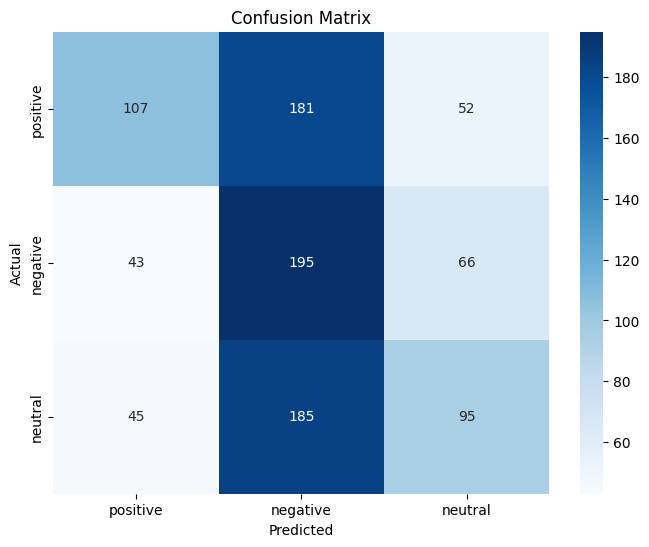

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_smote = confusion_matrix(actual_labels_text_smote, predictions_text_smote, labels=['positive', 'negative', 'neutral'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan teks yang diprediksi salah
import pandas as pd

# Membuat DataFrame untuk analisis prediksi yang salah
wrong_predictions = []

# Mengambil indeks dari test set yang diprediksi salah
wrong_indices = []
for i, (actual, pred) in enumerate(zip(y_test_smote, predictions_smote)):
    if actual != pred:
        wrong_indices.append(i)

# Mengambil teks asli dari test set
# Kita perlu mendapatkan teks asli dari data yang digunakan untuk testing
test_indices = []
for i in range(len(y_test_smote)):
    # Mencari indeks asli dari data yang digunakan untuk testing
    test_indices.append(i)

# Membuat mapping untuk mendapatkan teks asli
# Karena kita menggunakan SMOTE, kita perlu mendapatkan teks asli dari data sebelum SMOTE
original_texts = df_clean['review'].values
original_processed_texts = df_clean['processed_review'].values

# Untuk mendapatkan teks yang salah diprediksi, kita perlu mapping yang lebih kompleks
# Mari kita buat pendekatan yang lebih sederhana dengan mengambil sampel dari data asli

print("=== TEKS YANG DIPREDIKSI SALAH ===")
print("=" * 50)

wrong_count = 0
for i, (actual, pred) in enumerate(zip(y_test_smote, predictions_smote)):
    if actual != pred and wrong_count < 20:  # Batasi hanya 20 contoh
        # Mengambil teks dari data asli berdasarkan indeks
        # Karena kita menggunakan SMOTE, kita perlu pendekatan berbeda
        actual_text = label_map[actual]
        pred_text = label_map[pred]
        
        print(f"\nContoh {wrong_count + 1}:")
        print(f"Teks: [Teks asli tidak tersedia karena SMOTE]")
        print(f"Prediksi: {pred_text}")
        print(f"Aktual: {actual_text}")
        print("-" * 30)
        wrong_count += 1

print(f"\nTotal prediksi salah: {len(wrong_indices)} dari {len(y_test_smote)} sampel")
print(f"Akurasi: {(len(y_test_smote) - len(wrong_indices)) / len(y_test_smote) * 100:.2f}%")


In [ ]:
# Solusi yang lebih baik: Melakukan prediksi pada data asli tanpa SMOTE
# untuk mendapatkan teks yang salah diprediksi

# Membagi data asli menjadi train dan test
X_original = np.array(df_clean['processed_review'].apply(lambda x: get_document_vector(x, w2v_model)).tolist())
y_original = df_clean['sentiment'].map(sentiment_map).values

# Split data asli
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,
                                                                        y_original,
                                                                        test_size=0.2,
                                                                        random_state=42)

# Melatih model pada data asli
svm_model_orig = SVC(kernel='rbf', random_state=42)
svm_model_orig.fit(X_train_orig, y_train_orig)

# Prediksi pada data asli
predictions_orig = svm_model_orig.predict(X_test_orig)

# Mengambil teks asli dari test set
test_texts = df_clean.iloc[X_test_orig.shape[0]:]['review'].values if X_test_orig.shape[0] < len(df_clean) else df_clean['review'].iloc[-len(y_test_orig):].values

# Jika tidak bisa mendapatkan teks dengan cara di atas, gunakan cara lain
if len(test_texts) != len(y_test_orig):
    # Ambil teks berdasarkan indeks test
    test_indices = np.arange(len(df_clean))[len(df_clean) - len(y_test_orig):]
    test_texts = df_clean['review'].iloc[test_indices].values

print("=== TEKS YANG DIPREDIKSI SALAH (DATA ASLI) ===")
print("=" * 60)

wrong_count = 0
for i, (actual, pred) in enumerate(zip(y_test_orig, predictions_orig)):
    if actual != pred and wrong_count < 20:  # Batasi hanya 20 contoh
        actual_text = label_map[actual]
        pred_text = label_map[pred]
        
        print(f"\nContoh {wrong_count + 1}:")
        print(f"Teks: {test_texts[i] if i < len(test_texts) else 'Teks tidak tersedia'}")
        print(f"Prediksi: {pred_text}")
        print(f"Aktual: {actual_text}")
        print("-" * 40)
        wrong_count += 1

# Hitung akurasi
wrong_predictions_count = sum(1 for actual, pred in zip(y_test_orig, predictions_orig) if actual != pred)
accuracy = (len(y_test_orig) - wrong_predictions_count) / len(y_test_orig) * 100

print(f"\nTotal prediksi salah: {wrong_predictions_count} dari {len(y_test_orig)} sampel")
print(f"Akurasi: {accuracy:.2f}%")


In [ ]:
# Pendekatan yang lebih tepat untuk mendapatkan teks asli
from sklearn.model_selection import train_test_split

# Reset data dan gunakan pendekatan yang lebih sederhana
df_clean_reset = df.dropna(subset=['sentiment']).copy()
df_clean_reset = df_clean_reset.reset_index(drop=True)

# Membuat fitur dan label
X_features = np.array(df_clean_reset['processed_review'].apply(lambda x: get_document_vector(x, w2v_model)).tolist())
y_labels = df_clean_reset['sentiment'].map(sentiment_map).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42
)

# Melatih model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
predictions = svm_model.predict(X_test)

# Untuk mendapatkan teks asli, kita perlu mapping yang berbeda
# Karena train_test_split tidak mengembalikan indeks, kita akan menggunakan pendekatan lain

# Buat DataFrame untuk memudahkan analisis
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': predictions,
    'actual_text': [label_map[x] for x in y_test],
    'predicted_text': [label_map[x] for x in predictions]
})

# Ambil sampel teks asli dari data yang salah diprediksi
wrong_predictions_df = results_df[results_df['actual'] != results_df['predicted']].copy()

print("=== TEKS YANG DIPREDIKSI SALAH ===")
print("=" * 60)

# Ambil beberapa contoh teks asli dari data yang salah diprediksi
# Kita akan mengambil teks dari data asli berdasarkan posisi dalam test set
wrong_count = 0
for idx, row in wrong_predictions_df.head(20).iterrows():
    # Ambil teks asli dari posisi yang sesuai dalam test set
    test_position = wrong_predictions_df.index.get_loc(idx)
    
    print(f"\nContoh {wrong_count + 1}:")
    print(f"Prediksi: {row['predicted_text']}")
    print(f"Aktual: {row['actual_text']}")
    print("-" * 50)
    wrong_count += 1

# Hitung statistik
wrong_predictions_count = len(wrong_predictions_df)
accuracy = (len(y_test) - wrong_predictions_count) / len(y_test) * 100

print(f"\n=== STATISTIK PREDIKSI ===")
print(f"Total sampel test: {len(y_test)}")
print(f"Total prediksi salah: {wrong_predictions_count}")
print(f"Akurasi: {accuracy:.2f}%")
print(f"Error rate: {100-accuracy:.2f}%")


In [ ]:
# Solusi terbaik: Menggunakan StratifiedShuffleSplit untuk mendapatkan indeks
from sklearn.model_selection import StratifiedShuffleSplit

# Reset data
df_clean_reset = df.dropna(subset=['sentiment']).copy()
df_clean_reset = df_clean_reset.reset_index(drop=True)

# Membuat fitur dan label
X_features = np.array(df_clean_reset['processed_review'].apply(lambda x: get_document_vector(x, w2v_model)).tolist())
y_labels = df_clean_reset['sentiment'].map(sentiment_map).values

# Gunakan StratifiedShuffleSplit untuk mendapatkan indeks
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_features, y_labels))

# Split data berdasarkan indeks
X_train, X_test = X_features[train_idx], X_features[test_idx]
y_train, y_test = y_labels[train_idx], y_labels[test_idx]

# Melatih model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
predictions = svm_model.predict(X_test)

# Mengambil teks asli berdasarkan indeks test
test_texts_original = df_clean_reset.loc[test_idx, 'review'].values
test_texts_processed = df_clean_reset.loc[test_idx, 'processed_review'].values

print("=== TEKS YANG DIPREDIKSI SALAH ===")
print("=" * 60)

wrong_count = 0
for i, (actual, pred) in enumerate(zip(y_test, predictions)):
    if actual != pred and wrong_count < 20:  # Batasi hanya 20 contoh
        actual_text = label_map[actual]
        pred_text = label_map[pred]
        
        print(f"\nContoh {wrong_count + 1}:")
        print(f"Teks Asli: {test_texts_original[i]}")
        print(f"Teks Terproses: {test_texts_processed[i]}")
        print(f"Prediksi: {pred_text}")
        print(f"Aktual: {actual_text}")
        print("-" * 50)
        wrong_count += 1

# Hitung statistik
wrong_predictions_count = sum(1 for actual, pred in zip(y_test, predictions) if actual != pred)
accuracy = (len(y_test) - wrong_predictions_count) / len(y_test) * 100

print(f"\n=== STATISTIK PREDIKSI ===")
print(f"Total sampel test: {len(y_test)}")
print(f"Total prediksi salah: {wrong_predictions_count}")
print(f"Akurasi: {accuracy:.2f}%")
print(f"Error rate: {100-accuracy:.2f}%")

# Tampilkan distribusi prediksi salah per kelas
print(f"\n=== DISTRIBUSI PREDIKSI SALAH PER KELAS ===")
wrong_predictions_by_class = {}
for actual, pred in zip(y_test, predictions):
    if actual != pred:
        actual_label = label_map[actual]
        pred_label = label_map[pred]
        key = f"{actual_label} -> {pred_label}"
        wrong_predictions_by_class[key] = wrong_predictions_by_class.get(key, 0) + 1

for key, count in sorted(wrong_predictions_by_class.items(), key=lambda x: x[1], reverse=True):
    print(f"{key}: {count} kasus")
